## Data preparation

In [86]:
import numpy as np

labels = list()

with open('Cancerdata.txt') as f:
    lines = f.readlines()
    for i, line in enumerate(lines):
        if i == 0:
            continue
        line = line.split('\t')
        line = [item.rstrip() for item in line]
        line[0] = float(line[0].strip('"'))
        line[1:] = [float(x) for x in line[1:]]
        line = np.asarray(line)
        
        # Append labels
        labels.append(int(line[1]))
        
        # Create the data np.array with first observation
        # Vstack the rest of the observations to the newly created data matrix
        observation = line[2:]
        if i == 1:
            data = observation
        else:
            data = np.vstack((data, observation))
        
original_labels = np.asarray(labels)

print(np.shape(labels))
print(np.shape(data))

(82,)
(82, 2999)


## Step 1

### Dimension and feature selection techniques suited for unsupervised clustering tasks

1. Principal Component Analysis (PCA)
2. Independent Component Analysis (ICA)
3. Random Projections
4. Feature Selection based on Clustering Quality
5. Recursive Feature Elimination (RFE)

Principal Component Analysis (PCA): PCA is a technique that reduces the dimensionality of the data by identifying the most important features that capture the most variance in the data. PCA is a powerful technique for feature selection, as it can often reduce the number of features required for clustering while still retaining the important information.

Independent Component Analysis (ICA): ICA is a technique that separates the data into independent sources based on statistical properties. ICA can be used for feature selection by identifying the features that have the most independent information, which can help to remove redundant or noisy features.

Random Projections: Random projections is a technique that can be used to reduce the dimensionality of the data by projecting the data onto a lower-dimensional subspace. Random projections can be used for feature selection by identifying the most important dimensions that capture the most variance in the data.

Feature Selection based on Clustering Quality: This approach selects the features that produce the best clustering results. This method works by selecting a subset of features and evaluating the clustering performance with different clustering algorithms, and selecting the subset of features that results in the best clustering performance.

Recursive Feature Elimination (RFE): RFE is a feature selection method that selects features by recursively considering smaller and smaller subsets of features. RFE works by training a model on the full set of features, ranking the importance of the features, and then eliminating the least important feature. This process is repeated until a predetermined number of features is reached.

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


data_pp = StandardScaler().fit_transform(data)
pca = PCA(svd_solver="auto").fit(data_pp)
# The PCA object offers convenient ways of accessing the
# principal directions and explained variance
pca.components_;
pca.explained_variance_;

# To get the principal components, the `transform` method of the
# PCA object can be used
principal_components_pca = pca.transform(data_pp)
print(data.shape[1])

2999


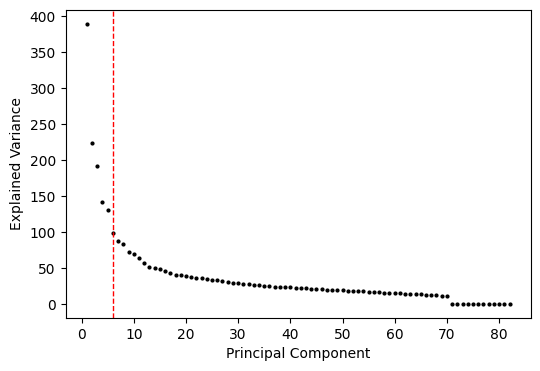

In [3]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6, 4))
ax = fig.gca()

ax.plot(np.arange(1, len(pca.explained_variance_) + 1), pca.explained_variance_, 'ok', markersize=2)
ax.axvline(6, linestyle="dashed", color="red", linewidth=1)

ax.set_xlabel("Principal Component")
ax.set_ylabel("Explained Variance");

3036.024691358023


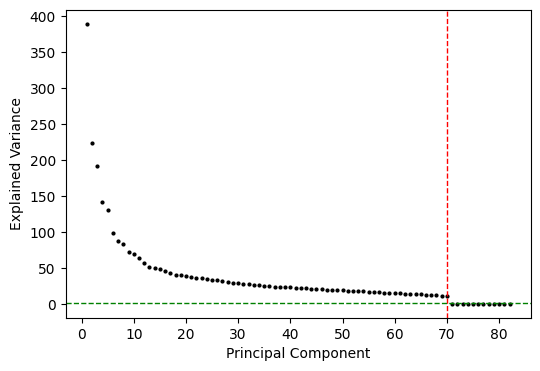

In [4]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6, 4))
ax = fig.gca()

ax.plot(np.arange(1, len(pca.components_) + 1), pca.explained_variance_, 'ok', markersize=2)
ax.axvline(70, linestyle="dashed", color="red", linewidth=1)
ax.axhline(1, linestyle="dashed", color="green", linewidth=1)

ax.set_xlabel("Principal Component")
ax.set_ylabel("Explained Variance");
print(pca.explained_variance_.sum())

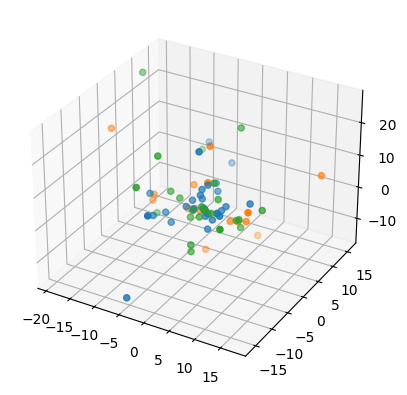

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

for i in range(0,3):
    ax.scatter(principal_components_pca[1, labels==i], principal_components_pca[2, labels==i],principal_components_pca[3, labels==i], label=i )

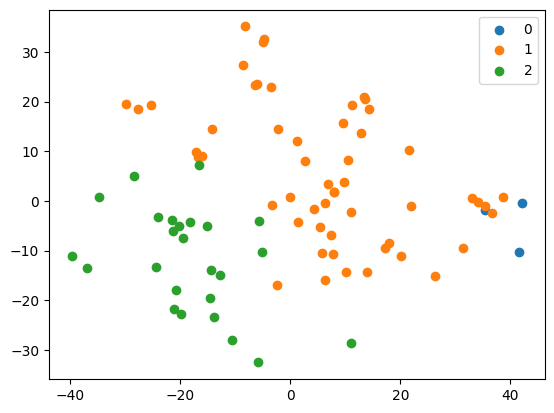

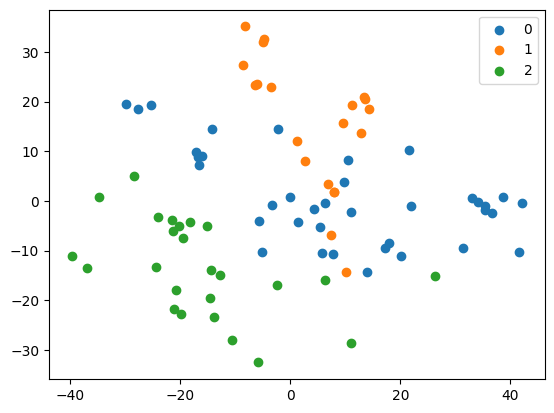

In [18]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 3, n_init="auto").fit(principal_components_pca)
#print(kmeans.cluster_centers_)
kmeans_label = kmeans.predict(principal_components_pca)

#Getting unique labels
 
u_labels = np.unique(label)
#plotting the results:
 
for i in u_labels:
    plt.figure(1)
    plt.scatter(principal_components_pca[kmeans_label == i , 0] , principal_components_pca[kmeans_label == i , 1] , label = i)
    plt.legend()
    plt.figure(2)
    plt.scatter(principal_components_pca[labels == i , 0] , principal_components_pca[labels == i , 1] , label = i)

    
plt.legend()
plt.show()

In [27]:
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV


def gmm_bic_score(estimator, X):
    """Callable to pass to GridSearchCV that will use the BIC score."""
    # Make it negative since GridSearchCV expects a score to maximize
    return -estimator.bic(X)


param_grid = {
    "n_components": range(1, 7),
    "covariance_type": ["spherical", "tied", "diag", "full"],
}
grid_search = GridSearchCV(
    GaussianMixture(), param_grid=param_grid, scoring=gmm_bic_score
)
grid_search.fit(principal_components_pca)

GridSearchCV(estimator=GaussianMixture(),
             param_grid={'covariance_type': ['spherical', 'tied', 'diag',
                                             'full'],
                         'n_components': range(1, 7)},
             scoring=<function gmm_bic_score at 0x00000213862DA0C0>)

In [39]:
import pandas as pd

df = pd.DataFrame(grid_search.cv_results_)[
    ["param_n_components", "param_covariance_type", "mean_test_score"]
]
df["mean_test_score"] = -df["mean_test_score"]
df = df.rename(
    columns={
        "param_n_components": "Number of components",
        "param_covariance_type": "Type of covariance",
        "mean_test_score": "BIC score",
    }
)
df.sort_values(by="BIC score").head(500)

,Number of components,Type of covariance,BIC score
12,1,diag,5.365155e+03
13,2,diag,5.708680e+03
14,3,diag,6.178467e+03
15,4,diag,6.616580e+03
16,5,diag,7.076048e+03
17,6,diag,7.607750e+03
0,1,spherical,8.926858e+03
1,2,spherical,9.101855e+03
2,3,spherical,9.341159e+03
3,4,spherical,9.538705e+03


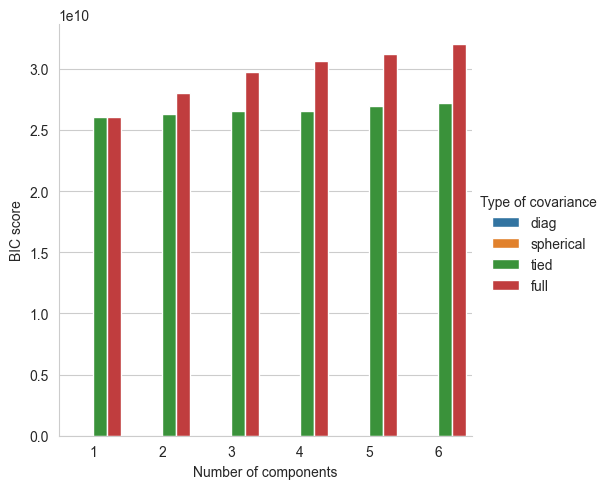

In [42]:
import seaborn as sns

sns.catplot(
    data=df,
    kind="bar",
    x="Number of components",
    y="BIC score",
    hue="Type of covariance",
)
plt.show()

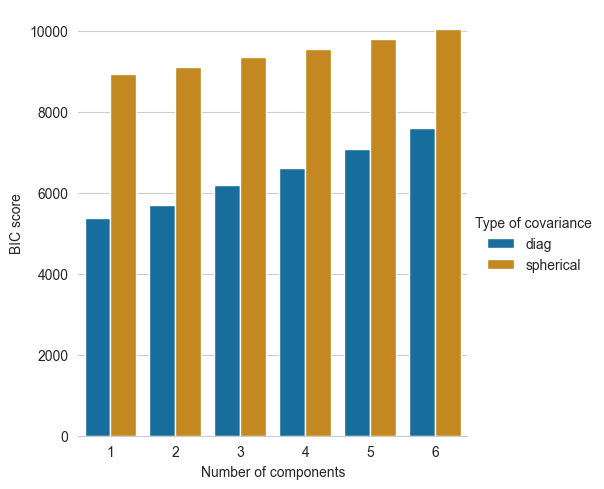

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a new dataframe for diagonal and spherical covariance types
df_diag_spherical = df.loc[df['Type of covariance'].isin(['diag', 'spherical'])]

# Create the bar plot
sns.set_style("whitegrid")
sns.set_palette("colorblind")
g = sns.catplot(
    data=df_diag_spherical,
    kind="bar",
    x="Number of components",
    y="BIC score",
    hue="Type of covariance",
    legend=False,
)
g.despine(left=True)
g.set_ylabels("BIC score")
g.set_xlabels("Number of components")
g.add_legend(title="Type of covariance")
plt.show()



In [31]:
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV

def gmm_bic_score(estimator, X):
    """Callable to pass to GridSearchCV that will use the BIC score."""
    # Make it negative since GridSearchCV expects a score to maximize
    return -estimator.bic(X)

# Set up the parameter grid for the GMM
param_grid = {
    "n_components": range(1, 7),
    "covariance_type": ["spherical", "tied", "diag", "full"],
}

# Set up the GMM object
gmm = GaussianMixture(max_iter=500, tol=1e-4)

# Set up the GridSearchCV object
grid_search = GridSearchCV(gmm, param_grid=param_grid, scoring=gmm_bic_score)

# Fit the GMM to the data with the specified covariance types
cov_types = ["spherical", "tied", "diag", "full"]
for cov_type in cov_types:
    gmm.set_params(covariance_type=cov_type)
    grid_search.fit(principal_components_pca)
    print(f"Best parameters for covariance type {cov_type}: {grid_search.best_params_}")


Best parameters for covariance type spherical: {'covariance_type': 'diag', 'n_components': 1}
Best parameters for covariance type tied: {'covariance_type': 'diag', 'n_components': 1}
Best parameters for covariance type diag: {'covariance_type': 'diag', 'n_components': 1}
Best parameters for covariance type full: {'covariance_type': 'diag', 'n_components': 1}


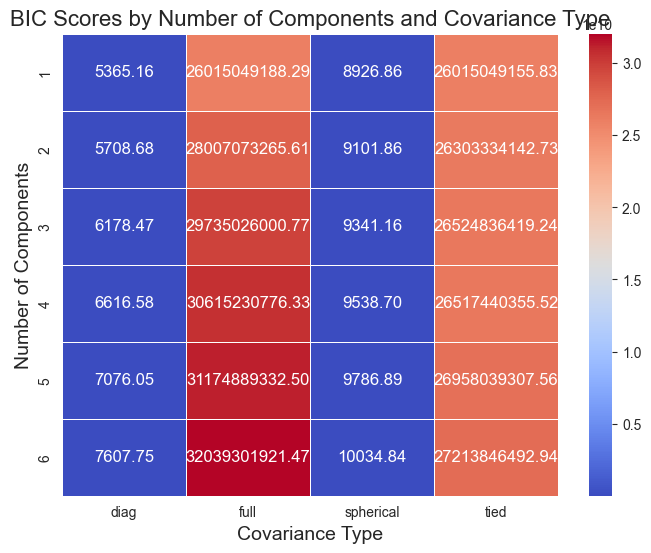

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Extract relevant data from grid search results
df = pd.DataFrame(grid_search.cv_results_)
df = df[df['param_n_components'] <= 6] # select up to 6 components
df = df[['param_covariance_type', 'param_n_components', 'mean_test_score']]
df['mean_test_score'] = -df['mean_test_score']

# Pivot table to show BIC scores by number of components and covariance type
table = pd.pivot_table(df, values='mean_test_score', index=['param_n_components'], columns=['param_covariance_type'])

# Set up plot
fig, ax = plt.subplots(figsize=(8, 6))

# Generate heatmap
sns.heatmap(table, cmap='coolwarm', annot=True, fmt='.2f', annot_kws={"fontsize":12}, linewidths=0.5, ax=ax)

# Set plot title and axis labels
ax.set_title('BIC Scores by Number of Components and Covariance Type', fontsize=16)
ax.set_xlabel('Covariance Type', fontsize=14)
ax.set_ylabel('Number of Components', fontsize=14)

# Show plot
plt.show()



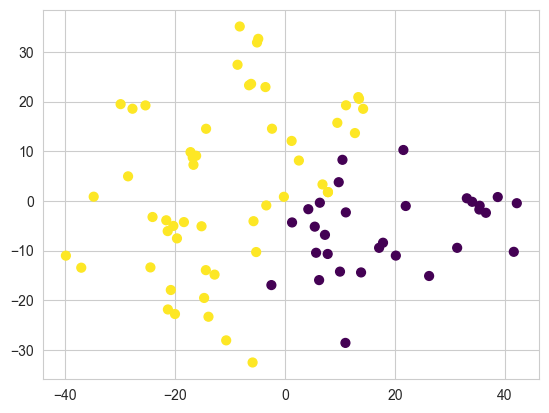

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.mixture import GaussianMixture




# Create a Gaussian Mixture Model object with 3 components
gmm = GaussianMixture(n_components=2)

# Fit the GMM to your data
gmm.fit(principal_components_pca)

# Predict the clusters of your data
labels = gmm.predict(principal_components_pca)

# Plot the data points and decision boundaries
plt.scatter(principal_components_pca[:, 0], principal_components_pca[:, 1], c=labels, s=40, cmap='viridis')
plt.show()


In [63]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(principal_components_pca, test_size=0.2, random_state=42)
# Fit GMM model
gmm = GaussianMixture(n_components=4, random_state=42)
gmm.fit(X_train)

# Evaluate performance using silhouette score
train_silhouette_score = silhouette_score(X_train, gmm.predict(X_train))
test_silhouette_score = silhouette_score(X_test, gmm.predict(X_test))

print(f"Training Silhouette Score: {train_silhouette_score}")
print(f"Test Silhouette Score: {test_silhouette_score}")

Training Silhouette Score: 0.0507594698387941
Test Silhouette Score: 0.08503727007579627


In [88]:
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split

def evaluate_clustering(X, model):
    # Split data into training and test sets
    X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

    # Fit model to training data
    model.fit(X_train)

    # Compute silhouette score for test set
    labels = model.predict(X_test)
    score = silhouette_score(X_test, labels)

    return score


In [89]:
score = evaluate_clustering(principal_components_pca, gmm)
print(score)

0.08503727007579627


In [83]:
def plot_true_vs_predict_2d(true_labels, predicted_labels, pca_component1=None, pca_component2=None):
    pca_component1 = 0 if pca_component1 is None else pca_component1
    pca_component2 = 1 if pca_component2 is None else pca_component2

    fig, (ax1, ax2) = plt.subplots(2)
    fig.set_size_inches(18.5, 10.5)

    colors1 = ['#000000', '#E69F00', '#56B4E9']
    colors2 = ['#009E73', '#D55E00', '#F0E442']
    plt.figure(3)

    for i in range(3):
        ax1.scatter(principal_components_pca[predicted_labels == i , pca_component1] , principal_components_pca[predicted_labels == i , pca_component2] , label = i, color=colors2[i])
        ax2.scatter(principal_components_pca[true_labels == i , pca_component1] , principal_components_pca[true_labels == i , pca_component2] , label = i, marker="8", color=colors1[i], zorder=5)

    plt.title('Plot of the real-label and predicted-label')
    ax1.set_xlabel('Principal component ' + str(pca_component1+1))
    ax2.set_ylabel('Principal component ' + str(pca_component2+1))
    ax2.set_xlabel('Principal component ' + str(pca_component1+1))
    ax1.set_ylabel('Principal component ' + str(pca_component2+1))
    ax1.set_title('Predicted')
    ax2.set_title('Real')

C:\Users\axelq\OneDrive\Skrivbord\MpCas\Statistical learning for big data\bigdatavenv1\Lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


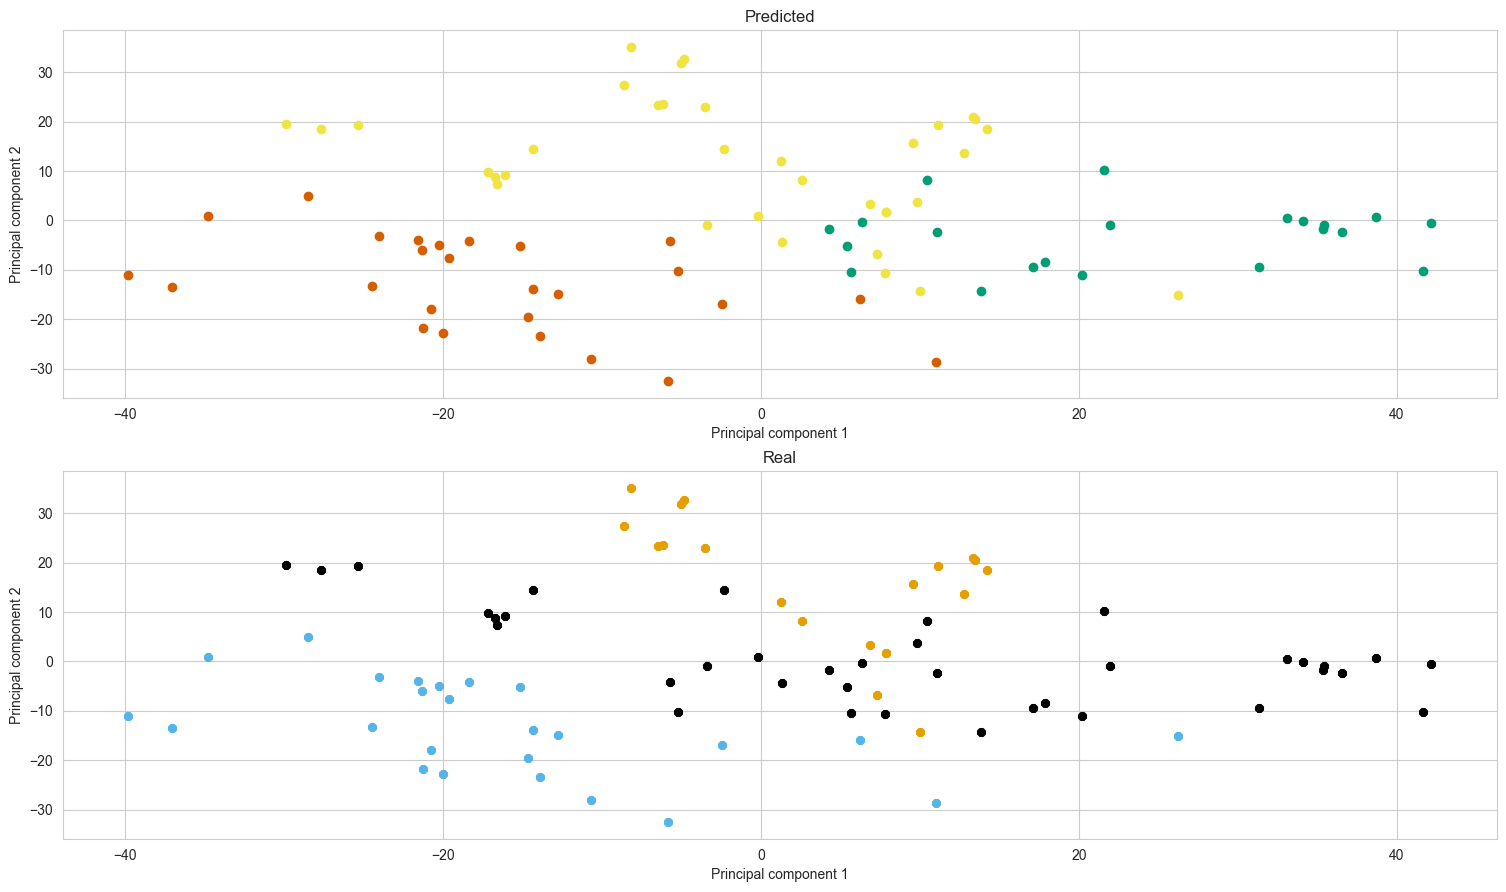

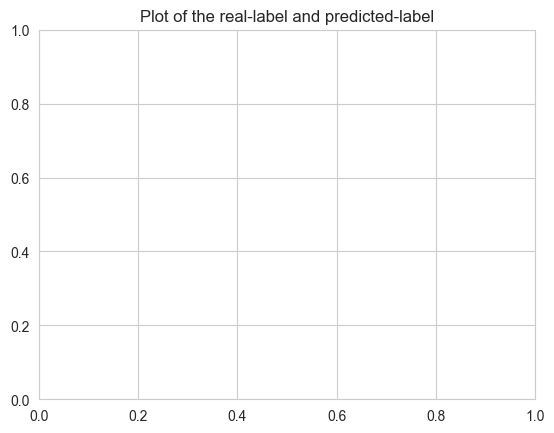

In [87]:
from sklearn.cluster import SpectralClustering
sc = SpectralClustering(n_clusters=3, eigen_solver='lobpcg', n_init=10, gamma=1.0, affinity='nearest_neighbors',
                        n_neighbors=10, assign_labels='cluster_qr')

sc_labels = sc.fit_predict(principal_components_pca)

plot_true_vs_predict_2d(original_labels, sc_labels)